# ADAML - Project 2

In [55]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from statsmodels.tsa.seasonal import STL, MSTL


In [56]:
df_test = pd.read_csv('data/DailyDelhiClimateTest.csv', index_col='date', parse_dates=True)
df_train = pd.read_csv('data/DailyDelhiClimateTrain.csv', index_col='date', parse_dates=True)

print(df_train.describe())


          meantemp     humidity   wind_speed  meanpressure
count  1462.000000  1462.000000  1462.000000   1462.000000
mean     25.495521    60.771702     6.802209   1011.104548
std       7.348103    16.769652     4.561602    180.231668
min       6.000000    13.428571     0.000000     -3.041667
25%      18.857143    50.375000     3.475000   1001.580357
50%      27.714286    62.625000     6.221667   1008.563492
75%      31.305804    72.218750     9.238235   1014.944901
max      38.714286   100.000000    42.220000   7679.333333


## Understanding the data

In [57]:
# Checking missing values
df_train.isnull().sum()


meantemp        0
humidity        0
wind_speed      0
meanpressure    0
dtype: int64

### Trend analysis

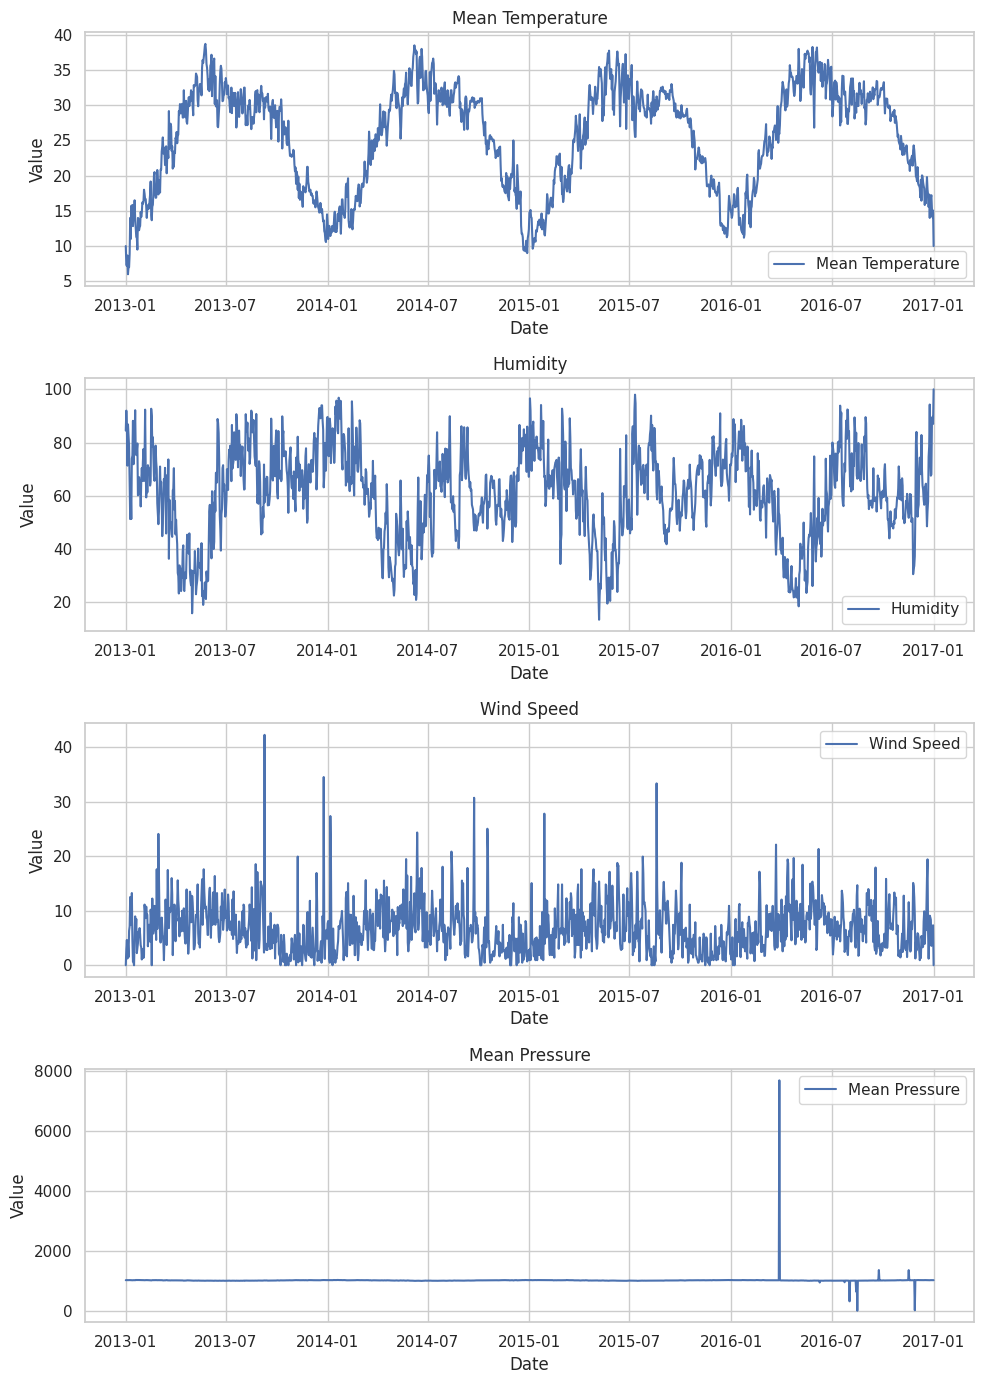

In [58]:
meantemp = df_train['meantemp']
humidity = df_train['humidity']
wind_speed = df_train['wind_speed']
meanpressure = df_train['meanpressure']

# Plotting each time series variable in separate subplots
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(10, 14))

# Plot for Mean Temperature
axes[0].plot(df_train.index, meantemp, label='Mean Temperature')
axes[0].set_title('Mean Temperature')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Value')
axes[0].legend()

# Plot for Humidity
axes[1].plot(df_train.index, humidity, label='Humidity')
axes[1].set_title('Humidity')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Value')
axes[1].legend()

# Plot for Wind Speed
axes[2].plot(df_train.index, wind_speed, label='Wind Speed')
axes[2].set_title('Wind Speed')
axes[2].set_xlabel('Date')
axes[2].set_ylabel('Value')
axes[2].legend()

# Plot for Mean Pressure
axes[3].plot(df_train.index, meanpressure, label='Mean Pressure')
axes[3].set_title('Mean Pressure')
axes[3].set_xlabel('Date')
axes[3].set_ylabel('Value')
axes[3].legend()

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


### Correlation between variables

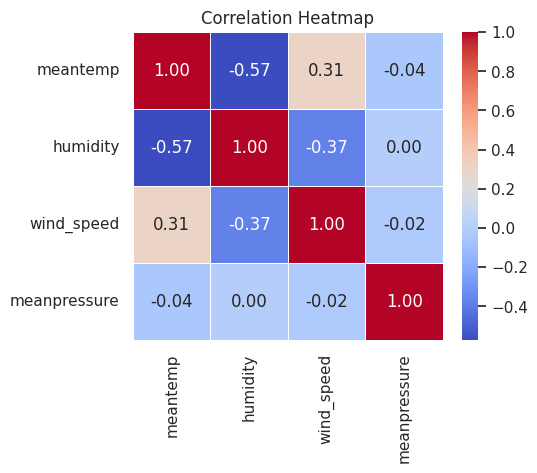

In [59]:
# Calculate the correlation matrix
correlation_matrix = df_train.corr()

# Create a heatmap
plt.figure(figsize=(5, 4))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title('Correlation Heatmap')
plt.show()


### Scatter/ pair plots 

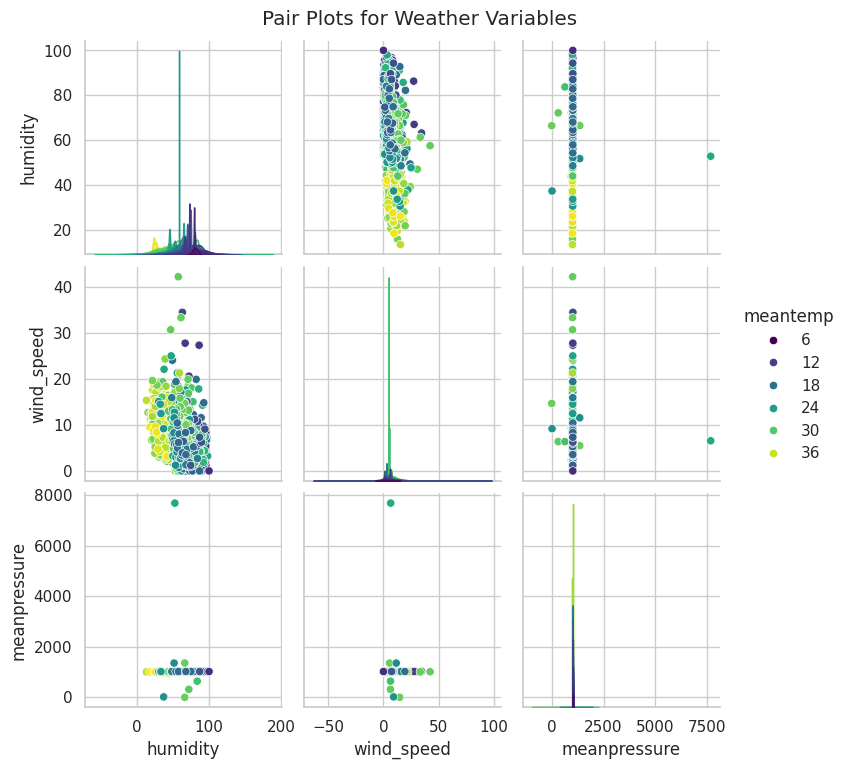

In [60]:
# Create pair plots (scatter plots) for selected variables
sns.set(style="whitegrid")
sns.pairplot(df_train, kind='scatter', palette='viridis', hue='meantemp')
plt.suptitle('Pair Plots for Weather Variables', y=1.02)
plt.show()


### Check for inconsistencies in timeseries

In [61]:
def check_inconsistencies(df_col):
    dates = df_col.strftime('%Y-%m-%d').to_numpy()
    dates = [datetime.strptime(date_str, '%Y-%m-%d') for date_str in dates]

    for i in range(len(dates) - 1):
        diff = dates[i] - dates[i+1]
        if diff != timedelta(days=-1):
            print('Problem')
            return

    print('Everything good')

check_inconsistencies(df_test.index)
check_inconsistencies(df_train.index)


Everything good
Everything good


## remove nonsensical values from the dataset

In [62]:
def plot_meanpressure_outliers():

    high_train = df_train["meanpressure"][df_train['meanpressure'] > 1070]
    low_train = df_train["meanpressure"][df_train['meanpressure'] < 980]

    high_test = df_test["meanpressure"][df_test['meanpressure'] > 1070]
    low_test = df_test["meanpressure"][df_test['meanpressure'] < 980]

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

    # Plot for train data
    ax1.plot(df_train["meanpressure"])
    ax1.scatter(high_train.index, high_train, color="red")
    ax1.scatter(low_train.index, low_train, color="red")
    ax1.set_title("Mean Pressure train data")
    ax1.set_xlabel("Date")
    ax1.set_ylabel("Mean Pressure")

    # Plot for test data
    ax2.plot(df_test["meanpressure"])
    ax2.scatter(high_test.index, high_test, color="red")
    ax2.scatter(low_test.index, low_test, color="red")
    ax2.set_title("Mean Pressure test data")
    ax2.set_xlabel("Date")
    ax2.set_ylabel("Mean Pressure")

    plt.tight_layout()
    plt.show()


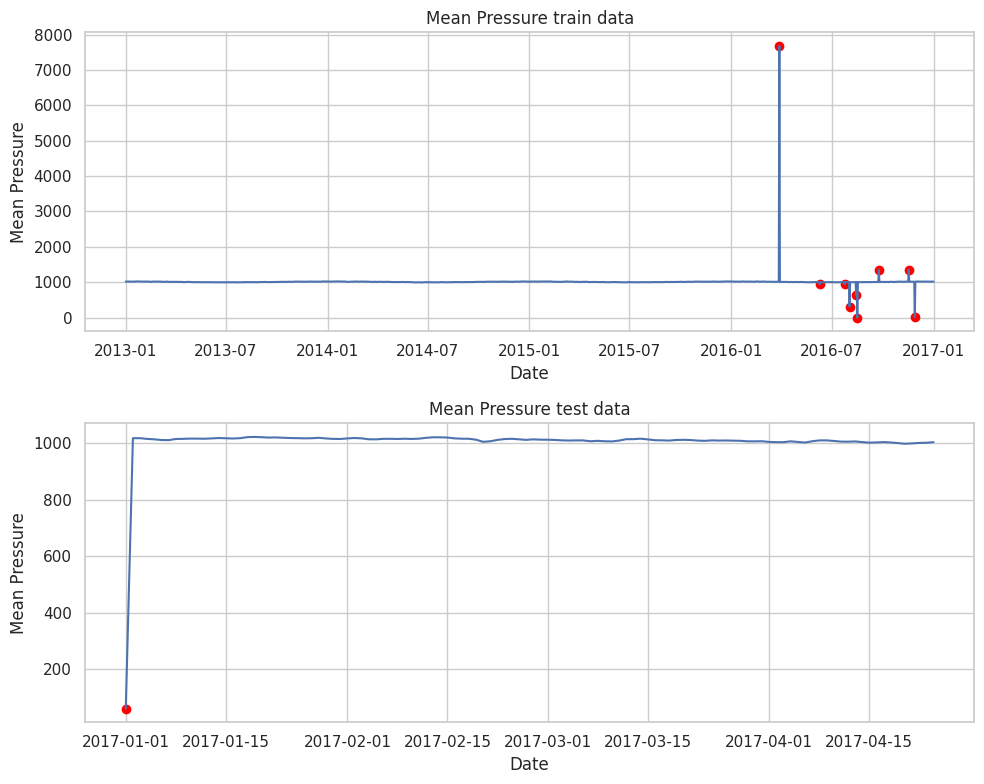

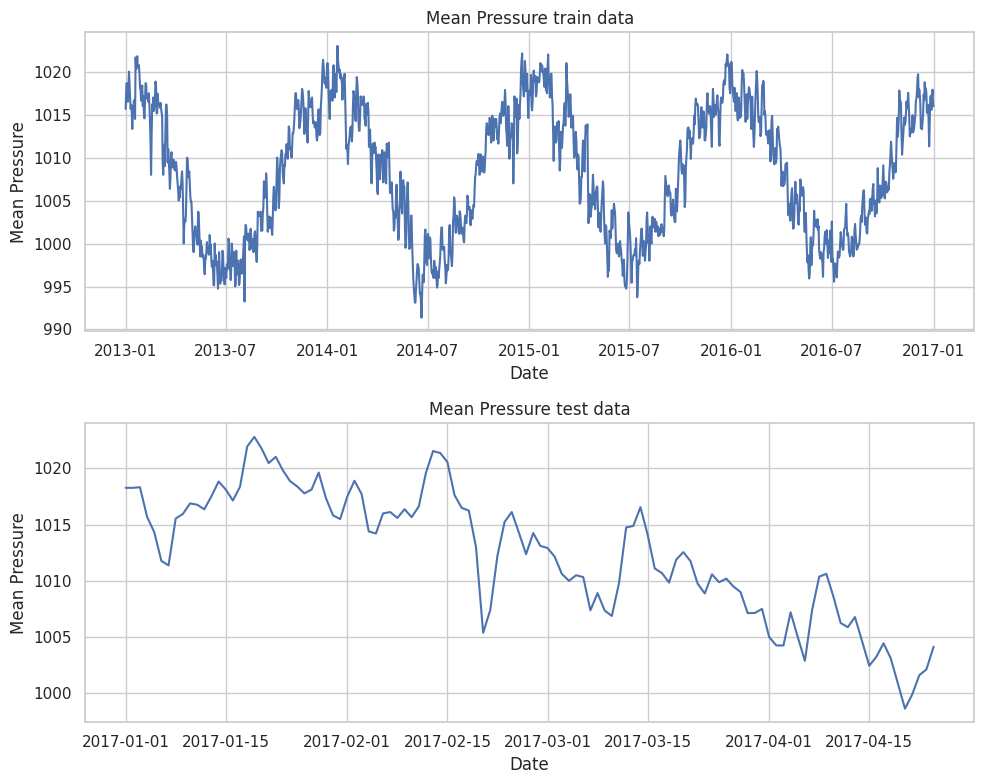

In [63]:
plot_meanpressure_outliers()

for index in df_train[df_train['meanpressure'] > 1070].index:
    prev_value = df_train.loc[index - 1 * timedelta(1), 'meanpressure']
    next_value = df_train.loc[index + 1 * timedelta(1), 'meanpressure']
    average = (prev_value + next_value) / 2
    df_train.loc[index, 'meanpressure'] = average


for index in df_train[df_train['meanpressure'] < 980].index:
    prev_value = df_train.loc[index - 1 * timedelta(1), 'meanpressure']
    next_value = df_train.loc[index + 1 * timedelta(1), 'meanpressure']
    average = (prev_value + next_value) / 2
    df_train.loc[index, 'meanpressure'] = average

# first row is an outlier and no great way of interpolating it, so I just copy next value into it
df_test["meanpressure"].iloc[0] = df_test["meanpressure"].iloc[1]
plot_meanpressure_outliers()


## Seasonality analysis

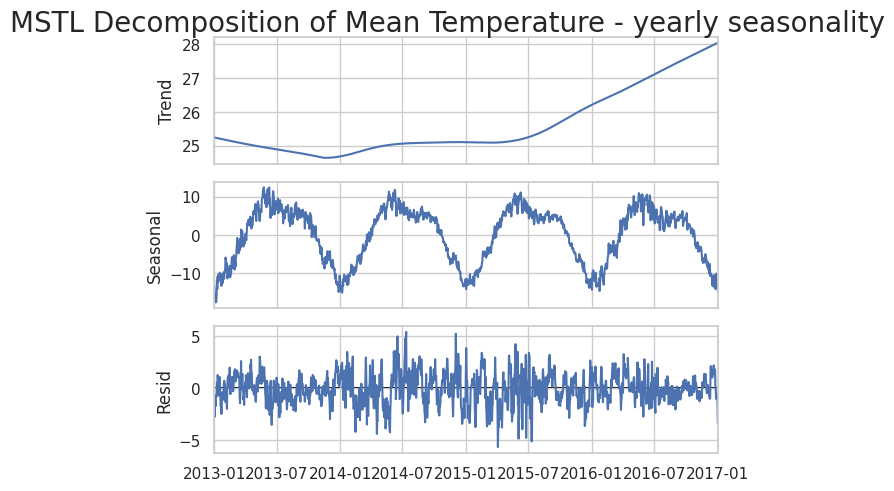

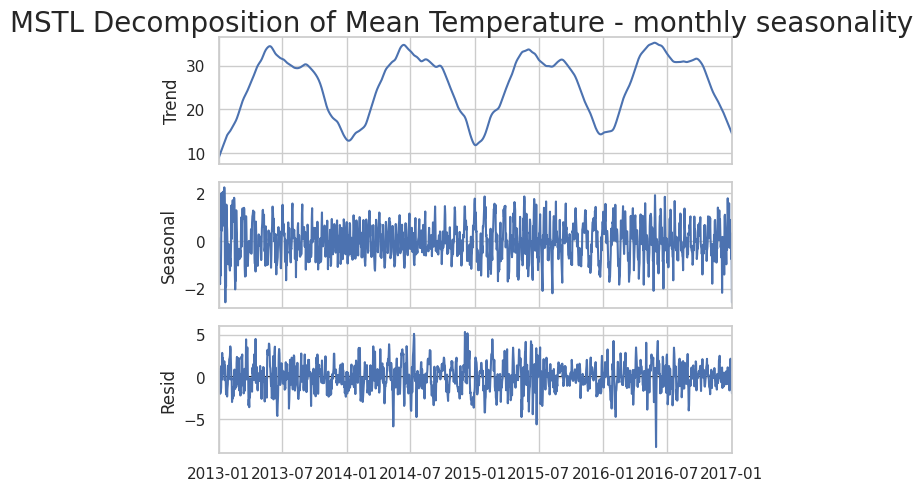

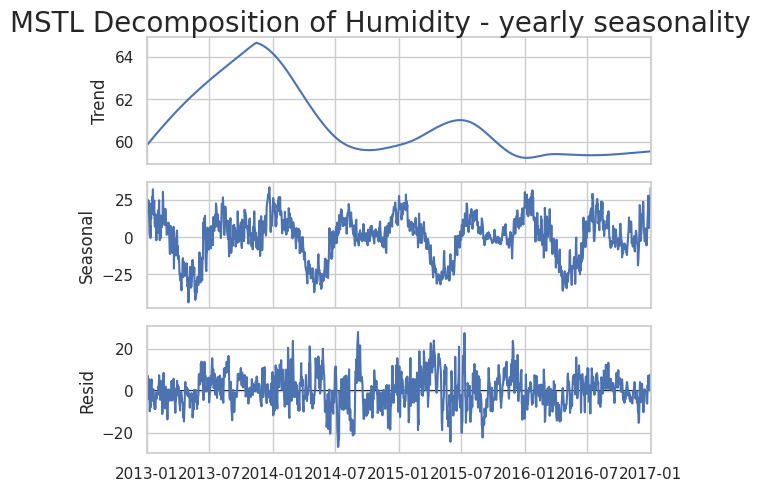

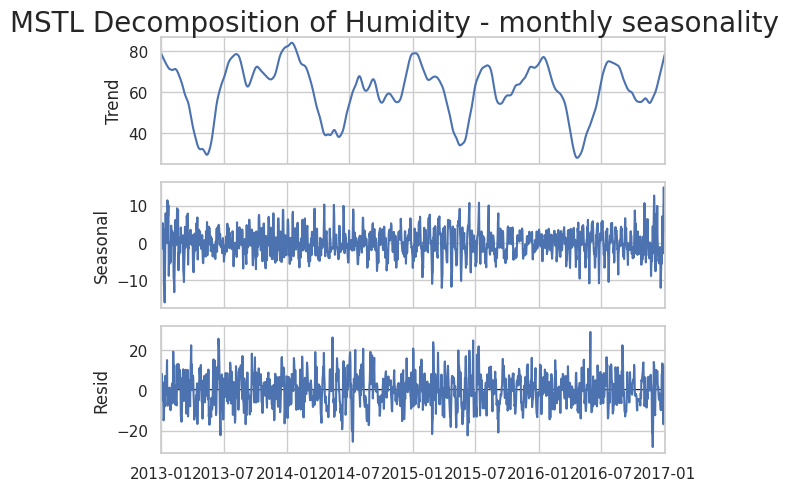

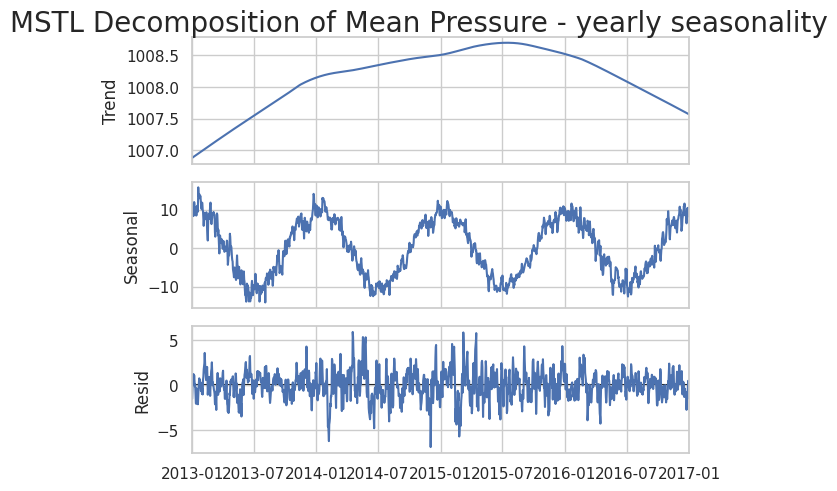

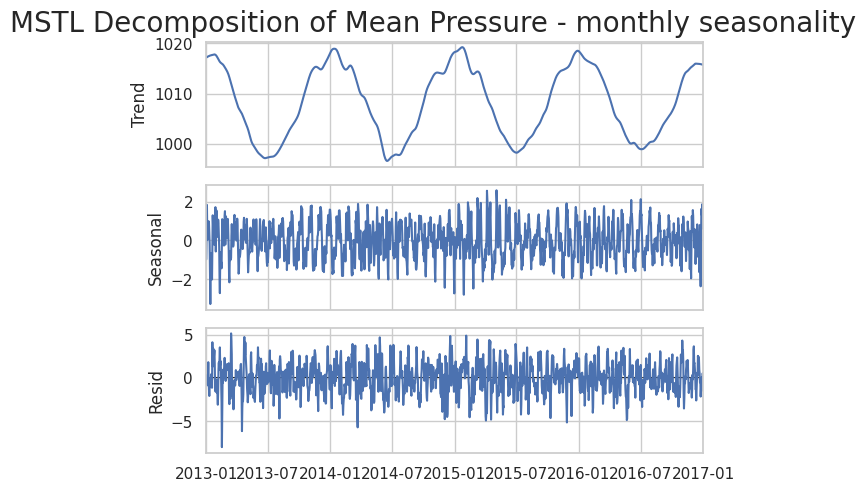

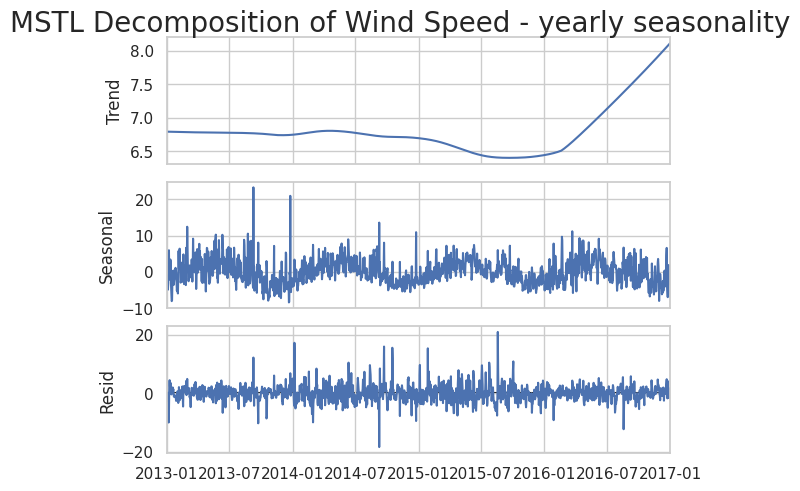

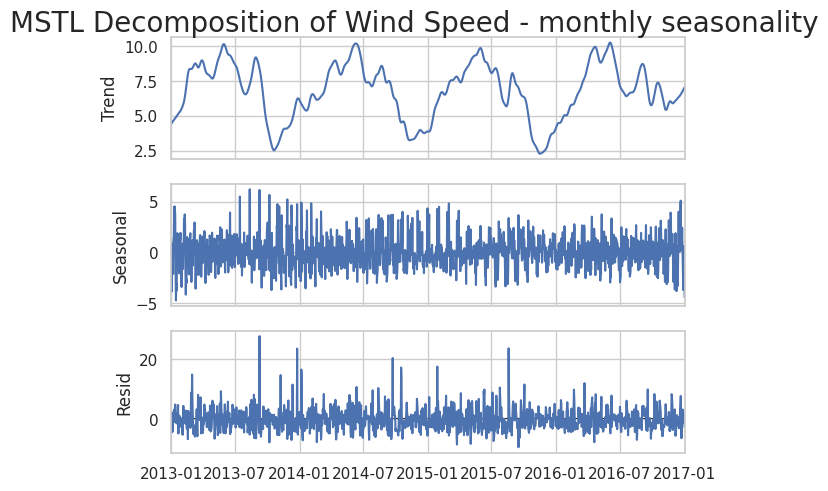

In [64]:
cols = [('meantemp', 'Mean Temperature'), ('humidity', 'Humidity'), ('meanpressure', 'Mean Pressure'), ('wind_speed', 'Wind Speed')]
periods = [(365, 'yearly'), (28, 'monthly')]

for col_idx, col_name in cols:
    for period, period_name in periods:
        mstl = MSTL(df_train[col_idx], periods=[period])
        res = mstl.fit()
        fig = res.plot(observed=False)
        fig.suptitle(f'MSTL Decomposition of {col_name} - {period_name} seasonality', fontsize=20, y=1.02);


## Outlier detection using STL decomposition

In [65]:
def find_outliers(col, col_name, df_name, threshold=3, period=None):
    stl = STL(col, period=period)
    result=stl.fit()
    residual = result.resid
    z_scores = (residual - residual.mean()) / residual.std()

    # detect outliers 3 stds from the mean
    outliers = col[abs(z_scores) > threshold]

    plt.figure(figsize=(12, 4))
    plt.plot(col, label='Samples')
    plt.scatter(outliers.index, outliers, color='red', label='Outliers')
    plt.legend()
    plt.title(f'Outlier detection of {col_name} in {df_name} set')
    plt.show()


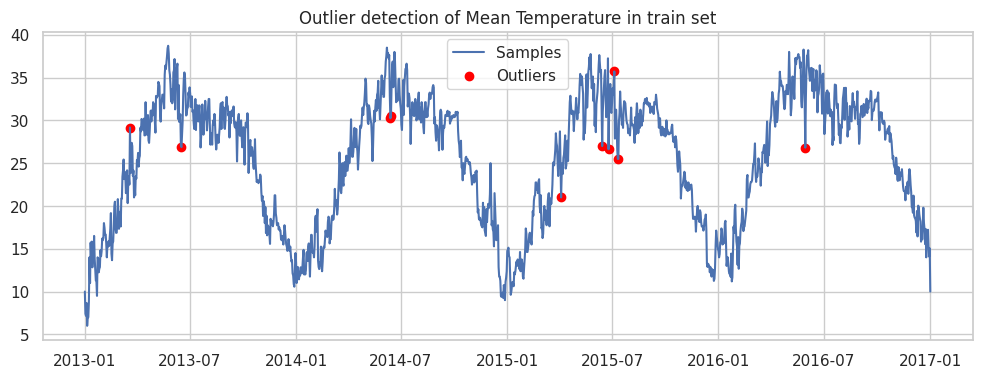

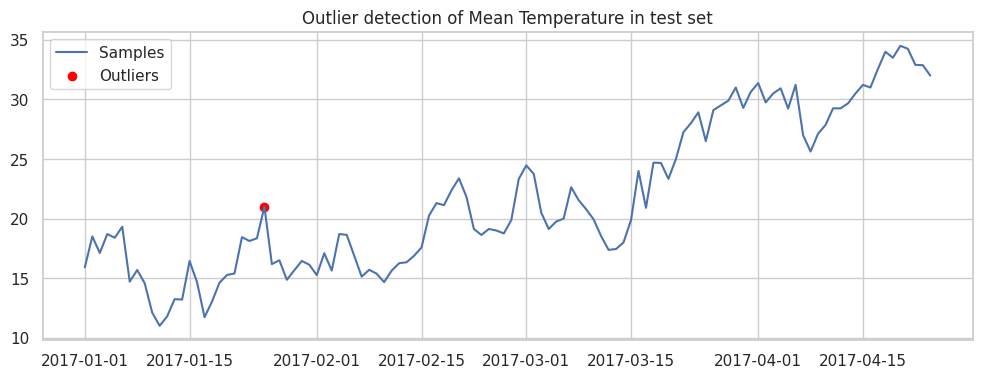

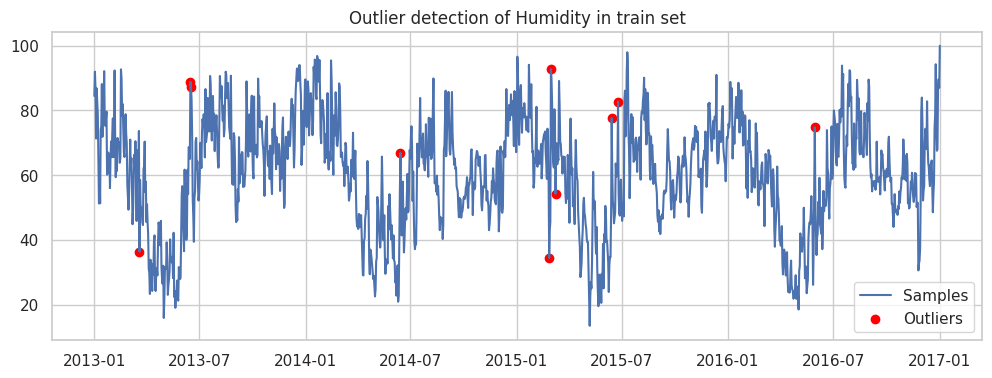

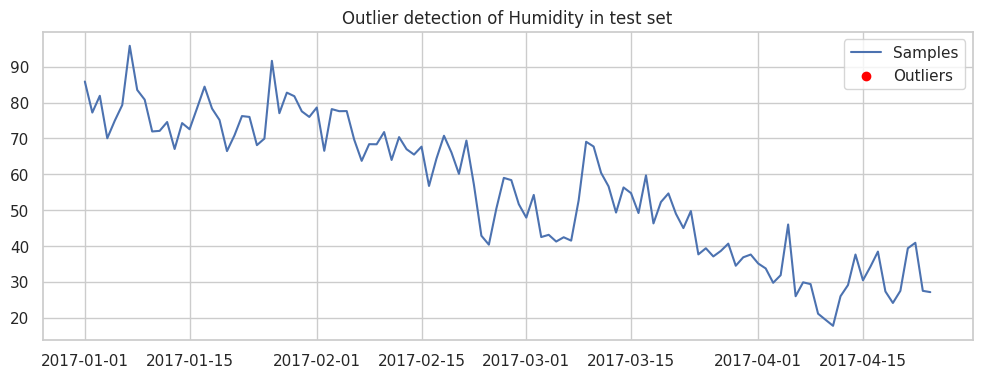

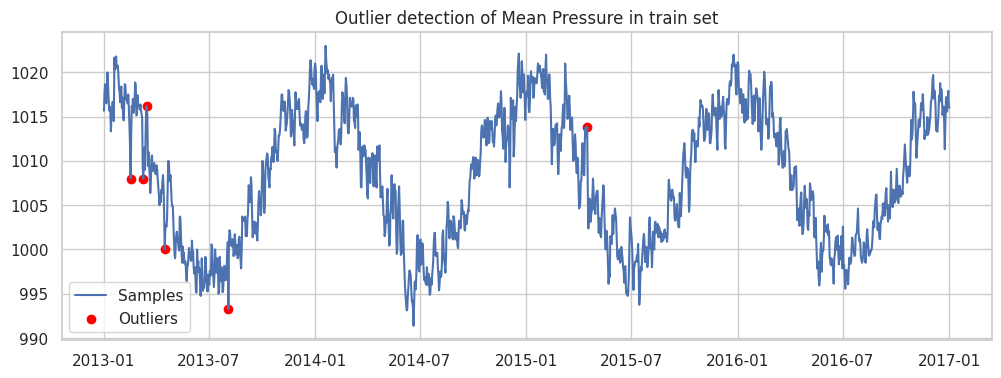

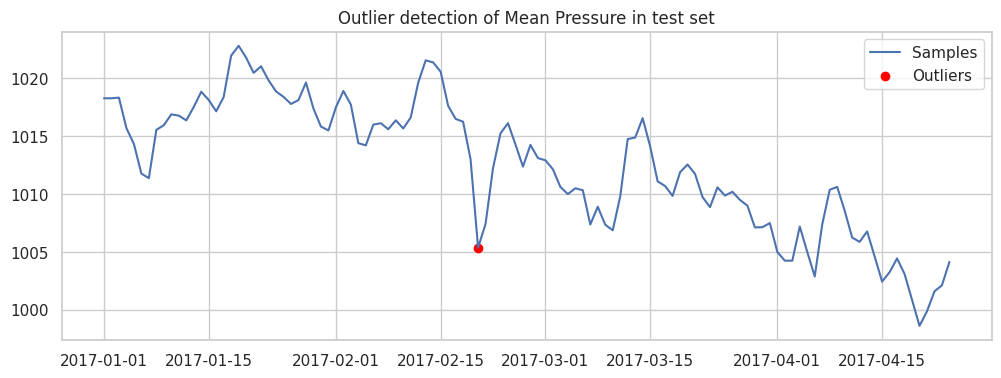

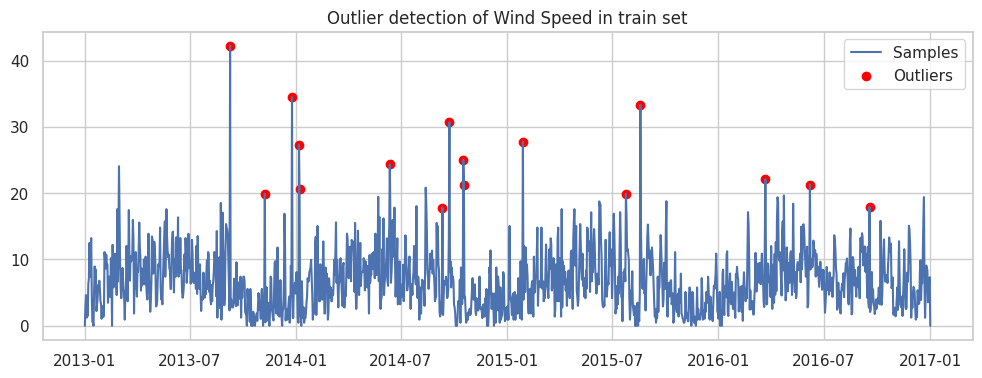

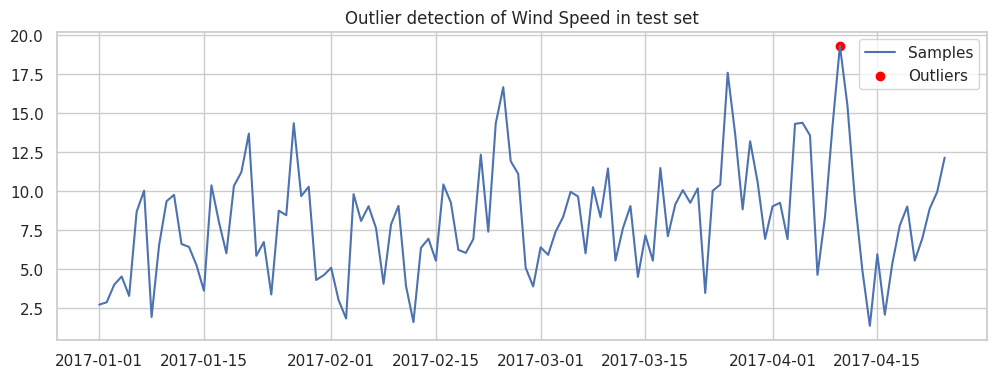

In [66]:
datasets = [('train', df_train), ('test', df_test)]

for col_idx, col_name in cols:
    for df_name, df in datasets:
        find_outliers(df[col_idx], col_name, df_name)
